In [1]:
import os
from os.path import exists
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.keras.layers import Embedding, Dense, LSTM, Flatten, ConvLSTM2D, Conv2D, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.interpolation import shift

import matplotlib.pyplot as plt
import math

from keras import backend as K

import time
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import random
import MetaTrader5 as mt5
# import libraries
import pandas as pd
from kerasbeats import prep_time_series, NBeatsModel

Num GPUs Available:  1


In [21]:
# -------------------------------------------
# Constan
# -------------------------------------------
# NumF = 1*24*60*60//24
# NumP = 24*60*60//24//10
# size_Reduce = (30*3)
minni_add = 15
mt5Range_time = mt5.TIMEFRAME_M15
maxCntCore = 100*24*60//minni_add
NumDataTrain = 30*24*60//minni_add
NumDataPerTest = 3*24*60//minni_add
NumF = 3*60//minni_add
NumBack = NumF*60//minni_add
NumP = 15//minni_add
size_Reduce = 1
min_delta_cmp = 200
nameFile = "data_BTCUSDm"
type_tick = "BTCUSDm"

In [26]:
# -------------------------------------------
# Model configuration
# -------------------------------------------
additional_metrics = [] #['binary_accuracy']
batch_size = NumBack
input_dims = 4
output_dims = 1
loss_function = "mae" #"mean_squared_error" "binary_crossentropy" "mae"
number_of_epochs = 100
optimizer = Adam()
validation_split = 0.01
verbosity_mode = 1

In [11]:
# -------------------------------------------
# Function
# -------------------------------------------
def hour_rounder(t):
    return t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
    
def demathPre(xValue, plus=False):
  global max_value, min_value, scaler
  xValue = scaler.inverse_transform(xValue.reshape((-1, 1)))
  xValue = np.float64(xValue)
  """
  if plus:
    xValue = xValue ** (1 / 4.0)
    xValue/=pow(10, 8)
    #xValue*=max_value
    xValue+=min_value
  #xValue = np.vectorize(lambda x: int(x >= 0.5))(xValue)
  return np.round(xValue, 6)
  """
  return np.round(xValue, 2).reshape(1, -1)
  #return np.round(xValue, 4)
def enmathPre(xValue, no_fit=False):
  global max_value, min_value, scaler
  """
  xValue-=min_value
  #xValue/=max_value
  xValue*=pow(10, 8)
  xValue**=4
  """
  if not no_fit:
    scaler.fit(xValue.reshape((-1, 1)))
  xValue = scaler.transform(xValue.reshape((-1, 1)))
  return xValue.reshape((-1,4))
def formatDataset(data, dataForY, scaler_x, num_in, num_out):
  global NumF, NumP, size_Reduce
  numData = len(data) - scaler_x - (NumF//size_Reduce - 1)
  x = np.zeros((numData, scaler_x, num_in), dtype = np.float64)
  y = np.zeros((numData, num_out), dtype = np.float64)
  for i in range(0, numData):
    x_child = np.zeros((scaler_x, num_in), dtype = np.float64)
    for j in range(0, scaler_x):
      x_child[j] = data[i + j]
    x[i] = x_child;
    for j in range(0, num_out):
        y[i] = data[i+scaler_x+j+(NumF//size_Reduce - 1)][3]
      # y[i] = (dataForY[i+scaler_x+j+5] >= dataForY[i+scaler_x+j+11])
  return (x, y)
def formatDataPredist(data, scaler_x, num_in):
  global NumF, NumP, size_Reduce
  numData = len(data) - scaler_x
  x = np.zeros((numData, scaler_x, num_in), dtype = np.float64)
  for i in range(0, numData):
    x_child = np.zeros((scaler_x, num_in), dtype = np.float64)
    for j in range(0, scaler_x):
      x_child[j] = data[i + j]
    x[i] = x_child;
  return x
def predictCon(input_dims, scale_x, scale_y, data):
  global model, np, random
  test_x = np.zeros((scale_x, input_dims))
  for i in range(0, scale_x):
    test_x[i] = data[i]
  test_y = np.zeros((len(data) - scale_x,  scale_y))
  for i in range(0, len(data) - scale_x):
    test_y[i] = model.predict(test_x.reshape((1, scale_x, input_dims))).T[0][0]
    shift(test_x, -scale_y, cval=np.zeros((input_dims)))
    for j in range(scale_x-scale_y, scale_x):
      test_x[j] = test_y[i][j - scale_x + scale_y] + (random.random()*2*0.03 - 0.035)
  return test_y
def extract_seqX_outcomeY(data, scale_x, input_dims):
  test_x = np.zeros((len(data) - scale_x, scale_x, input_dims), dtype = np.float64)
  for i in range(0, len(data) - scale_x):
    test_x_child = data[i:i+scale_x]
    test_x[i] = test_x_child;
  return test_x
def DrawPlot(data, up_x, label, date = [], step = 1, noinv = False):
  global demathPre
  tranfor = demathPre
  if tranfor and (not noinv):
    data = tranfor(data)
  data = data.reshape((-1))
  if len(date) == 0:
    date = np.zeros(data.shape)
    for i in range(0, len(data), step):
      date[i] = i + up_x
  plt.plot(date, data, label = label)
def reduceSizeArr(data, child_size):
  num_child = len(data)//child_size
  child_arr = np.zeros((num_child, 1), dtype = np.float64);
  for i in range(0, num_child):
    child_value = 0.0;
    for j in range(0, child_size):
      child_value = child_value + data[i*child_size + j]/child_size
    child_arr[i] = child_value;
  return child_arr
def calPrize(val_l, val_r, mode):
  re_val = (val_l[3] - val_r[3])*mode
  return re_val;
def find_best_pos(data):
  minest = data.argmin()
  maxest = data.argmax()
  return (min(minest, maxest), max(minest, maxest))
def fomatDataFinal(data):
    global input_dims, NumBack
    X_beta = data.reshape((input_dims, -1, NumBack))
    X_time = X_beta[input_dims - 1]
    # create training data from non time values
    X_non_time = np.zeros((input_dims-1, len(X_beta[0]), NumBack), dtype=np.float64)
    for i in range(0, input_dims-1):
        X_non_time[i] = X_beta[i]
    X_non_time = X_non_time.reshape((-1,input_dims - 1, NumBack))
    return [X_time, X_non_time]

In [5]:
# connect to MetaTrader 5
if not mt5.initialize(login=96414403, password="8zVtw5FGfc4bvus", server='Exness-MT5Trial6'):
    print("initialize() failed, error code =",mt5.last_error())
    mt5.shutdown()
 
# request connection status and parameters
print(mt5.terminal_info())
# get data on MetaTrader 5 version
print(mt5.version())

TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=3337, maxbars=100000, codepage=0, ping_last=38272, community_balance=0.0, retransmission=0.0, company='Exness Technologies Ltd', name='MetaTrader 5 EXNESS', language='English', path='C:\\Program Files\\MetaTrader 5 EXNESS', data_path='C:\\Users\\nhson\\AppData\\Roaming\\MetaQuotes\\Terminal\\53785E099C927DB68A545C249CDBCE06', commondata_path='C:\\Users\\nhson\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
(500, 3337, '30 Jun 2022')


In [6]:
# -------------------------------------------
# Get data realtime
# -------------------------------------------
cntCore = []

# file_exists = exists(nameFile)
file_exists = False
if file_exists == False:
    timezone = datetime.timezone.utc
    utc_from = datetime.datetime.now(timezone)
    Data_ticks = mt5.copy_rates_from(type_tick, mt5Range_time, utc_from, maxCntCore)
    # BTCUSDm
    SStock = datetime.datetime.utcfromtimestamp(Data_ticks[len(Data_ticks)-1]['time'].item()) + datetime.timedelta(hours=7)
    data = np.zeros((len(Data_ticks), 4), dtype = np.float64)
    for i in range(0, len(data)):
      data[i][0] = Data_ticks[i]['open']
      data[i][1] = Data_ticks[i]['high']
      data[i][2] = Data_ticks[i]['low']
      data[i][3] = Data_ticks[i]['close']
    SaveData = np.copy(data)
    with open(nameFile, 'wb') as f:
        np.save(f, SaveData)
else:
    with open(nameFile, 'rb') as f:
        SaveData = np.load(f)

min_value = np.min(SaveData)
max_value = np.max(SaveData)
scaler = StandardScaler()

In [7]:
# -------------------------------------------
# Format size data
# -------------------------------------------
noChangeData = np.copy(SaveData)
enmathPre(noChangeData)
lenData = NumDataTrain*size_Reduce+(NumBack)
orgData = np.copy(noChangeData[len(noChangeData)-lenData:])
# test_orgData = np.copy(orgData) * 10000
test_orgData = np.copy(orgData)
print(noChangeData.shape, orgData.shape)

orgData = enmathPre(orgData, no_fit=True)

data = np.copy(orgData[:len(orgData) - (NumF//size_Reduce)])
dataForY = np.copy(test_orgData[:len(test_orgData) - (NumF//size_Reduce)])
print(data.shape)

(9600, 4) (2928, 4)
(2916, 4)


In [55]:
X_dev, y_dev = prep_time_series(data.reshape((4, -1))[3], lookback = NumBack//NumF, horizon = NumF)
print(X_dev)

[[-1.43469979 -1.4147807  -1.4348338  ... -1.43803669 -1.44978347
  -1.44315352]
 [-1.4147807  -1.4348338  -1.41815415 ... -1.44978347 -1.44315352
  -1.4431584 ]
 [-1.4348338  -1.41815415 -1.41785201 ... -1.44315352 -1.4431584
  -1.43935367]
 ...
 [-1.31099919 -1.30873316 -1.30876971 ... -1.29035643 -1.29034546
  -1.28308931]
 [-1.30873316 -1.30876971 -1.30257104 ... -1.29034546 -1.28308931
  -1.29252986]
 [-1.30876971 -1.30257104 -1.31071654 ... -1.28308931 -1.29252986
  -1.28398598]]


In [56]:
# -------------------------------------------
# Format data
# -------------------------------------------
(X, y) = formatDataset(data, dataForY, NumBack, 4, 1)
print(X.shape, y.shape)

(2857, 48, 4) (2857, 1)


In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
shuffle = False, test_size = 0.01)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2828, 48, 4) (29, 48, 4) (2828, 1) (29, 1)


In [58]:
X_train_beta = X_train.reshape((4, -1, NumBack))
X_time_train = X_train_beta[3]
X_test_beta = X_test.reshape((4, -1, NumBack))
X_time_test = X_test_beta[3]
print(X_time_train.shape, X_time_test.shape)
# create training data from non time values
X_non_time_train = np.zeros((3, len(X_train_beta[0]), NumBack), dtype=np.float64)
X_non_time_train[0] = X_train_beta[0]
X_non_time_train[1] = X_train_beta[1]
X_non_time_train[2] = X_train_beta[2]
X_non_time_train = X_non_time_train.reshape((-1,3, NumBack))
# create training data from non time values
X_non_time_test = np.zeros((3, len(X_test_beta[0]), NumBack), dtype=np.float64)
X_non_time_test[0] = X_test_beta[0]
X_non_time_test[1] = X_test_beta[1]
X_non_time_test[2] = X_test_beta[2]
X_non_time_test = X_non_time_test.reshape((-1,3, NumBack))

print(X_non_time_train.shape, X_non_time_test.shape)

(2828, 48) (29, 48)
(2828, 3, 48) (29, 3, 48)


In [65]:
K.clear_session()

In [66]:
# initialize
nbeats = NBeatsModel(model_type = 'generic', lookback = NumBack//NumF, horizon = NumF)
nbeats.build_layer()
# this is the base NBeats layer that"s used to construct the model
nbeats.model_layer

In [74]:
time_input = tf.keras.layers.Input(shape = (NumBack, ))
# layer we created from the previous block
nbeats_layer = nbeats.model_layer(time_input)
# input for non time data
non_time_input = tf.keras.layers.Input(shape = (3,NumBack,))
x_flatten = tf.keras.layers.Flatten()(non_time_input)
x = tf.keras.layers.Dense(32*NumBack)(x_flatten)
#concatenate the layers and combine into a model
concat = tf.keras.layers.Concatenate()([nbeats_layer, x])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs = [time_input, non_time_input], outputs = output)

model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 3, 48)]      0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 flatten_6 (Flatten)            (None, 144)          0           ['input_14[0][0]']               
                                                                                                  
 n_beats (NBeats)               (None, 12)           25190400    ['input_13[0][0]']               
                                                                                              

In [75]:
# -------------------------------------------
# Train model
# -------------------------------------------
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, mode="min", min_delta=0.001, restore_best_weights=True) #,min_delta=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20,min_delta=0.001, mode="min", restore_best_weights=True,)
history = model.fit([X_time_train, X_non_time_train], y_train, validation_split=validation_split, batch_size=64, epochs=number_of_epochs, verbose=verbosity_mode, callbacks=[early_stopping], shuffle=False) #, shuffle=True, callbacks=[early_stopping])

Epoch 1/30
44/44 [==============================] - 14s 113ms/step - loss: 381.8355 - val_loss: 11.9468
Epoch 2/30
44/44 [==============================] - 3s 71ms/step - loss: 6.8010 - val_loss: 1.5537
Epoch 3/30
44/44 [==============================] - 3s 71ms/step - loss: 0.4610 - val_loss: 0.0423
Epoch 4/30
44/44 [==============================] - 3s 70ms/step - loss: 0.1839 - val_loss: 0.2942
Epoch 5/30
44/44 [==============================] - 3s 72ms/step - loss: 0.2562 - val_loss: 0.0330
Epoch 6/30
44/44 [==============================] - 3s 68ms/step - loss: 0.1735 - val_loss: 0.1662
Epoch 7/30
44/44 [==============================] - 3s 67ms/step - loss: 0.1751 - val_loss: 0.2996
Epoch 8/30
44/44 [==============================] - 3s 67ms/step - loss: 0.1644 - val_loss: 0.2491
Epoch 9/30
44/44 [==============================] - 3s 67ms/step - loss: 0.1833 - val_loss: 0.0761
Epoch 10/30
44/44 [==============================] - 3s 68ms/step - loss: 0.2195 - val_loss: 0.3074
Epoc

In [ ]:
print(history.history)

In [76]:
model.save_weights("./exai_nbeat.h", overwrite=True, save_format=None, options=None)

In [102]:
model.load_weights('./exai_nbeat.h')

In [77]:
y_predist = demathPre(model.predict([X_time_test, X_non_time_test]))
print(X_time_test.shape, X_non_time_test.shape)
print(y_predist.shape)

1/1 [==============================] - 2s 2s/step
(29, 48) (29, 3, 48)
(1, 29)


In [78]:
print(y_predist[0])

[21892.36 21918.93 22011.37 22063.71 21894.79 21925.22 22019.25 22059.22
 21897.77 21906.4  22008.43 22027.38 21899.97 21898.19 22004.93 22004.96
 21906.07 21913.31 22020.71 22003.41 21909.62 21931.27 22010.43 21999.25
 21904.29 21928.05 22001.77 21981.68 21889.17]


In [79]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate([X_time_test, X_non_time_test], y_test, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
1/1 [==============================] - 0s 52ms/step - loss: 0.1782
test loss, test acc: 0.17817001044750214


 100


(9600, 4) (300, 4)
(288, 4)
(229, 48, 4) (229, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 48)]      0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 flatten (Flatten)              (None, 144)          0           ['input_2[0][0]']                
                                                                                                  
 n_beats (NBeats)               (None, 12)           25190400    ['input_1[0][0]']                
                                            

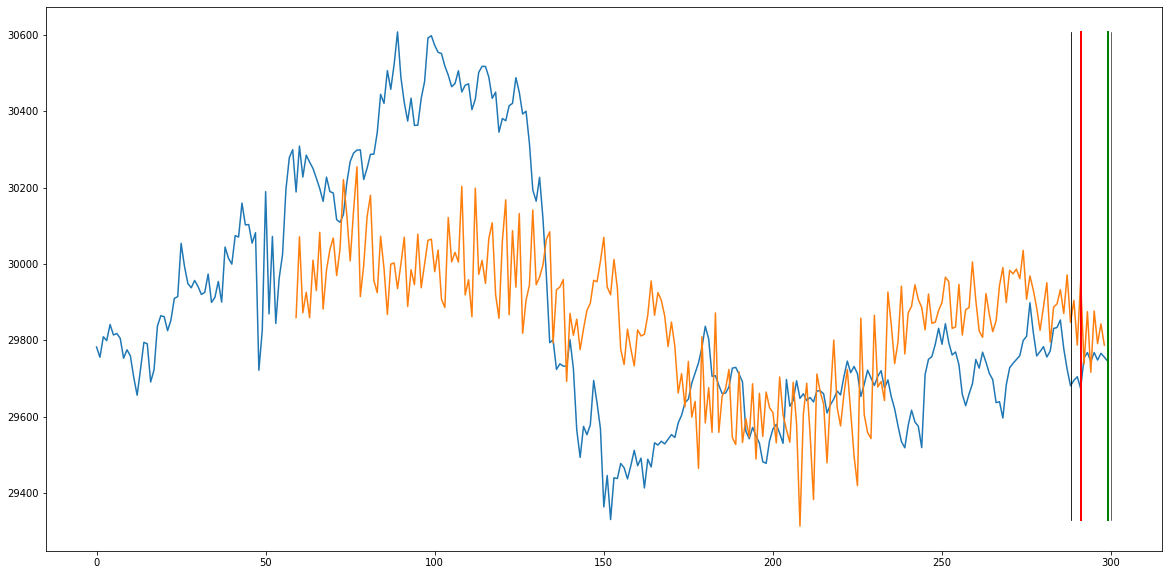

Bonus:  -71.5199999999968
Acc money 9928.480000000003
Loop:  1  /  100  | win(  0  ) / loss(  1  )
(9600, 4) (300, 4)
(288, 4)
(229, 48, 4) (229, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 48)]      0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 flatten (Flatten)              (None, 144)          0           ['input_2[0][0]']                
                                                                                                  
 n_beats (NBeats)               (None, 12)  

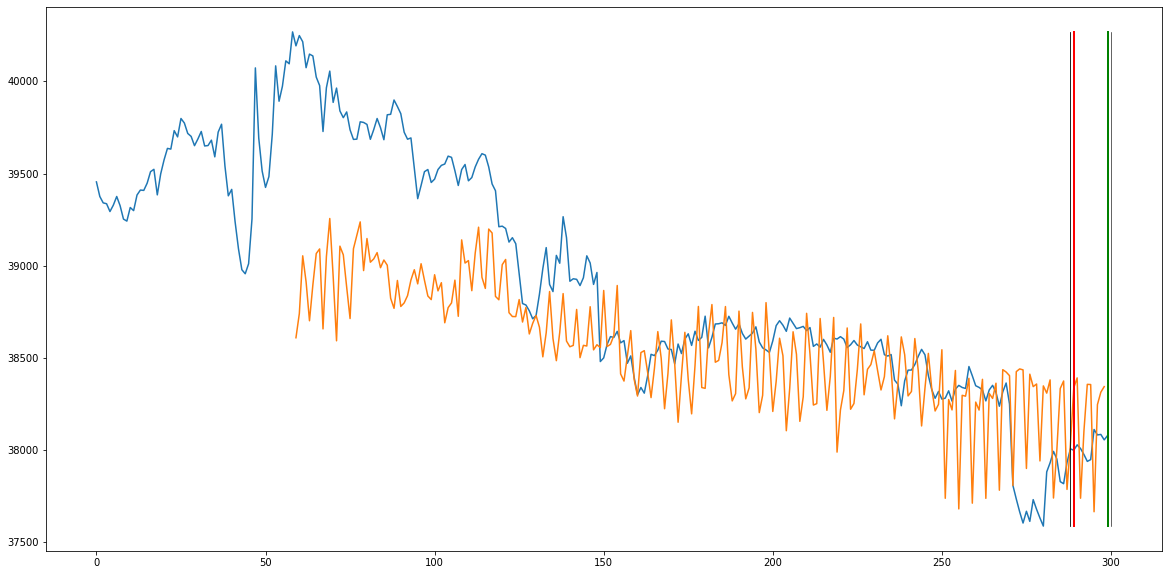

Bonus:  79.87999999999738
Acc money 10008.36
Loop:  2  /  100  | win(  1  ) / loss(  1  )
(9600, 4) (300, 4)
(288, 4)
(229, 48, 4) (229, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 48)]      0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 flatten (Flatten)              (None, 144)          0           ['input_2[0][0]']                
                                                                                                  
 n_beats (NBeats)               (None, 12)           

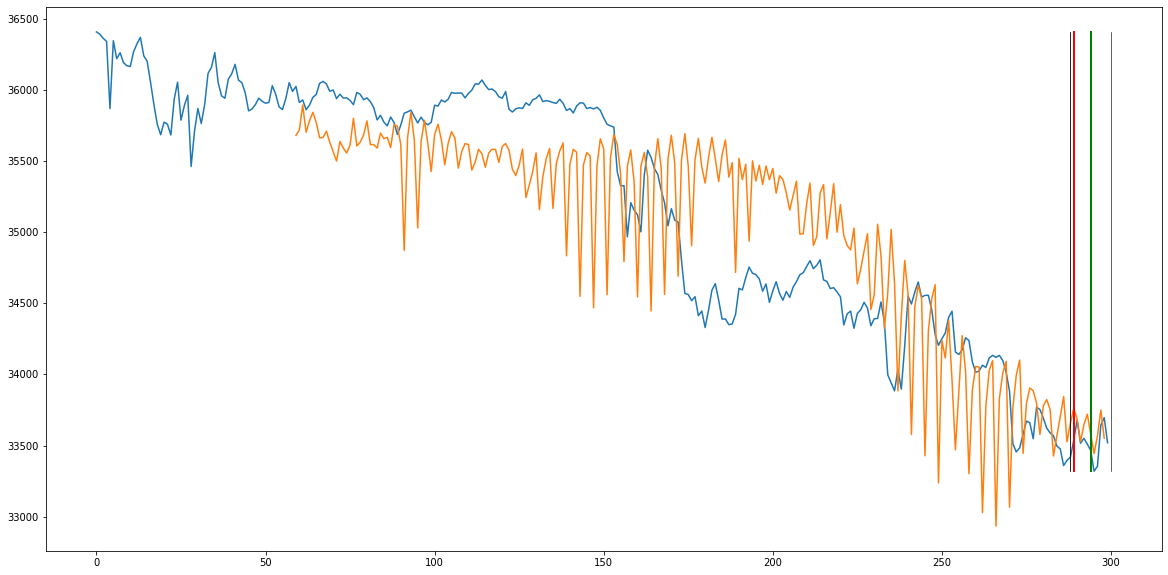

Bonus:  -71.80000000000291
Acc money 9936.559999999998
Loop:  3  /  100  | win(  1  ) / loss(  2  )
(9600, 4) (300, 4)
(288, 4)
(229, 48, 4) (229, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 48)]      0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 flatten (Flatten)              (None, 144)          0           ['input_2[0][0]']                
                                                                                                  
 n_beats (NBeats)               (None, 12) 

KeyboardInterrupt: 

In [31]:
# -------------------------------------------
# Function AI
# -------------------------------------------
def runAI(noChangeData):
  global scaler, NumF, NumP, size_Reduce, NumDataPerTest
  # -------------------------------------------
  # Format size data
  # -------------------------------------------
  lenData = NumDataPerTest*size_Reduce+(NumF)
  ranPos = np.random.randint(lenData, len(noChangeData) + 1)
  orgData_forT = np.copy(noChangeData[len(noChangeData)-ranPos:len(noChangeData)-ranPos+lenData])
  # test_orgData = np.copy(orgData) * 10000
  test_orgData_forT = np.copy(orgData_forT)
  print(noChangeData.shape, orgData_forT.shape)

  orgData_forT = enmathPre(orgData_forT)

  data = np.copy(orgData_forT[:len(orgData_forT) - (NumF//size_Reduce)])
  dataForY = np.copy(test_orgData_forT[:len(test_orgData_forT) - (NumF//size_Reduce)])
  print(data.shape)
    
  # -------------------------------------------
  # Format data
  # -------------------------------------------
  (X, y) = formatDataset(data, dataForY, NumBack, 4, 1)
  print(X.shape, y.shape)

  K.clear_session()
  # initialize
  nbeats = NBeatsModel(model_type = 'generic', lookback = NumBack//NumF, horizon = NumF)
  nbeats.build_layer()
  # this is the base NBeats layer that"s used to construct the model
  nbeats.model_layer

  time_input = tf.keras.layers.Input(shape = (NumBack, ))
  # layer we created from the previous block
  nbeats_layer = nbeats.model_layer(time_input)
  # input for non time data
  non_time_input = tf.keras.layers.Input(shape = (3,NumBack,))
  x_flatten = tf.keras.layers.Flatten()(non_time_input)
  x = tf.keras.layers.Dense(32*NumBack)(x_flatten)
  #concatenate the layers and combine into a model
  concat = tf.keras.layers.Concatenate()([nbeats_layer, x])
  output = tf.keras.layers.Dense(1)(concat)
  model = tf.keras.Model(inputs = [time_input, non_time_input], outputs = output)

  model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
  model.summary()

  # -------------------------------------------
  # Train model
  # -------------------------------------------
  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, mode="min", min_delta=0.001, restore_best_weights=True) #,min_delta=0.00001)
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,min_delta=0.001, mode="min", restore_best_weights=True,)
  history = model.fit(fomatDataFinal(X), y, validation_split=validation_split, epochs=60, verbose=verbosity_mode, callbacks=[], shuffle=False) #, shuffle=True, callbacks=[early_stopping])
    
  # -------------------------------------------
  # Real result
  # -------------------------------------------
  pos_predist_data = len(data)-1*batch_size-(NumF - NumP + 1)
  test_last_x_All = np.copy(data[pos_predist_data:])
  test_last_x_All = fomatDataFinal(formatDataPredist(test_last_x_All, batch_size, input_dims))
  print(test_last_x_All[0].shape, test_last_x_All[1].shape)
  test_last_y_All = model.predict(test_last_x_All)
  print(test_last_y_All.shape)
  test_last_y_All = demathPre(test_last_y_All, plus=True)
  print(test_last_y_All.shape)

  (pos_l, pos_r) = find_best_pos(test_last_y_All);
  print(pos_l, pos_r)
  BackPrize = test_last_y_All[0][pos_l]
  test_last_y = test_last_y_All[0][pos_r]
  
  #BackPrize = test_orgData[len(test_orgData)-7] / 10000
  print("Predist: ", BackPrize, " / ", test_last_y)
  test_sellorbuy = (BackPrize - test_last_y >= min_delta_cmp)
  test_NoBuyNoSell = (abs(BackPrize - test_last_y) <= min_delta_cmp)
  print("Result: ", ("No BUY!" if test_NoBuyNoSell else ("Sell" if test_sellorbuy else "Buy"))) 
  
  orgData_close = np.zeros((len(orgData_forT)), dtype = np.float64);
  for i in range(0, len(orgData_forT)):
    orgData_close[i] = orgData_forT[i][3]
  
  len_range = (NumF - NumP + 1)
  print("CMP l: ", test_orgData_forT[len(test_orgData_forT) - len_range + pos_l])
  print("CMP r: ", test_orgData_forT[len(test_orgData_forT) - len_range + pos_r])

  CopyData = np.copy(data)
  fig = plt.figure(figsize = (20,10))
  test_x = extract_seqX_outcomeY(CopyData, np.copy(batch_size), input_dims)
  test_y = model.predict(fomatDataFinal(test_x))
  print(orgData_close.shape)
  DrawPlot(orgData_close.reshape((-1)), 0, 'Train 0', date = [], step = 1)
  print(test_y.shape)
  DrawPlot(test_y.reshape((-1)), np.copy(batch_size) + (NumF - 1)//size_Reduce, 'Predicted Closing Price', date = [], step = 1)
  valSpitPos = len(orgData_close)
  minline = np.min(demathPre(orgData_close))
  maxline = np.max(demathPre(orgData_close))


  plt.plot([valSpitPos - len_range + pos_l, valSpitPos - len_range + pos_l], [minline, maxline], 'r-', lw=2)
  plt.plot([valSpitPos - len_range + pos_r, valSpitPos - len_range + pos_r], [minline, maxline], 'g-', lw=2)

  plt.plot([valSpitPos-(NumF//size_Reduce), valSpitPos-(NumF//size_Reduce)], [minline, maxline], 'k-', lw=0.6)
  plt.plot([valSpitPos, valSpitPos], [minline, maxline], 'k-', lw=0.6)
  plt.plot([valSpitPos-(NumF - NumP + 1)//size_Reduce, valSpitPos-(NumF - NumP + 1)//size_Reduce], [minline, maxline], 'k-', lw=0.6)
  plt.show()
    
  """
  fig = plt.figure(figsize = (20,10))
  DrawPlot(orgData, 0, 'Train 0', date = [])
  test_x = extract_seqX_outcomeY(orgData, batch_size, input_dims)
  test_y = model.predict(test_x)
  for i in range(0, 1):
      DrawPlot(test_y.T[i], batch_size + 11 + i, 'Predicted Closing Price (' + str(i) + ')', date = [])
  plt.show()
  """
  
  # -------------------------------------------
  # Print output
  # -------------------------------------------
  #pos_evel = int(len(x_train)*(1.0-validation_split))
  #scores = model.evaluate(x_train[:pos_evel], y_train[:pos_evel], verbose=0)
  #print("Accuracy see: %.2f%%" % (scores[1]*100), y_train[:pos_evel].shape)
  if test_NoBuyNoSell:
    return 0
  elif test_sellorbuy == 1:
    return calPrize(test_orgData_forT[len(test_orgData_forT) - len_range + pos_l], test_orgData_forT[len(test_orgData_forT) - len_range + pos_r], 1)
  elif test_sellorbuy == 0:
    return calPrize(test_orgData_forT[len(test_orgData_forT) - len_range + pos_l], test_orgData_forT[len(test_orgData_forT) - len_range + pos_r], -1)
  
  return 0
    
Money = 10000
numItems = 1
arrMoney = []
numLoop = int(input())
winG = 0
lossG = 0
for i in range(0, numLoop):
  newSaveData = np.copy(SaveData)
  status = runAI(newSaveData)
  if status > 0:
    winG = winG + 1
  if status < 0:
    lossG = lossG + 1
  print("Bonus: ", status*numItems)
  Money = Money + status*numItems
  print("Acc money", Money)
  arrMoney.append(Money)
  print("Loop: ", (i+1), " / ", numLoop, " | win( ", winG, " ) / loss( ", lossG, " )")
  #time.sleep(0.6)

fig = plt.figure(figsize = (20,10))
arrMoney = np.array(arrMoney)
DrawPlot(arrMoney, 0, 'Acc money', date = [], noinv=True)
plt.show()